In [84]:
import json
import pandas as pd
import numpy as np
import ccxt
from tqdm import tqdm
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import pandas_ta as ta 
from pytorch_tabnet.tab_model import TabNetClassifier 


In [85]:
chart_df = pd.read_csv("chart_df_with_deberta_sentiments.csv") 
targets = [] 
high = chart_df["high"].values 
low = chart_df["low"].values 
close = chart_df["close"].values 

threshold = 0.01 

for i in range(len(close)-1):
    high_vol = (high[i+1] - close[i]) / close[i] 
    low_vol = (low[i+1] - close[i]) / close[i] 
    if high_vol >= threshold: 
        targets.append(0) 
    elif low_vol <= -threshold:
        targets.append(1) 
    else:
        targets.append(2) 
        
targets.append(None) 

chart_df["Targets"] = targets 

In [86]:
chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)

### addition of chart features ### 
chart_df["bop"] = chart_df.ta.bop(lookahead=False) 
chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
chart_df["vwap"] = chart_df.ta.vwap(lookahead=False) 
chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100
chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
chart_df["close/open"] = chart_df["close"] / chart_df["open"] 
chart_df["high/open"] = chart_df["high"] / chart_df["open"] 
chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
chart_df["hwma"] = chart_df.ta.hwma(lookahead=False) 
#chart_df["linreg"] = chart_df.ta.linreg(lookahead=False) 
chart_df["hwma/close"] = chart_df["hwma"] / chart_df["close"] 
#chart_df["linreg/close"] = chart_df["linreg"] / chart_df["close"] 

    
### addition of recent differenced features ### 
for l in range(1, 12): 
    #for col in ["open", "high", "low", "close", "volume", "vwap"]:
    for col in ["high", "low", "volume", "vwap"]:
        val = chart_df[col].values 
        val_ret = [None for _ in range(l)]
        for i in range(l, len(val)):
            if val[i-l] == 0: 
                ret = 1 
            else:
                ret = val[i] / val[i-l]  
            val_ret.append(ret) 
        chart_df["{}_change_{}".format(col, l)] = val_ret
        
### drop unnecessary columns ### 
chart_df.drop(columns={"open","high","low","close","volume","vwap","hwma"}, inplace=True) 


chart_df.dropna(inplace=True)

print(chart_df.shape)  


(10929, 61)


In [87]:
columns = chart_df.columns 

train_columns = [] 

for c in columns:
    if c not in ["year","datetime","Targets"]: 
        train_columns.append(c) 
        
        
train_idx = int(chart_df.shape[0] * 0.8) 
val_idx = int(chart_df.shape[0] * 0.1)
train_df, val_df, test_df = chart_df.iloc[:train_idx], chart_df.iloc[train_idx:train_idx+val_idx], chart_df.iloc[train_idx+val_idx:]


train_df.shape, val_df.shape, test_df.shape


((8743, 61), (1092, 61), (1094, 61))

In [88]:
chart_df.dropna(inplace=True)
X_train = train_df[train_columns] 
Y_train = train_df["Targets"]

X_val = val_df[train_columns] 
Y_val = val_df["Targets"] 

X_test = test_df[train_columns] 
Y_test = test_df["Targets"] 


class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(Y_train),
                                     y = Y_train) 

class_weights


array([0.86969064, 1.21785764, 0.97176837])

In [91]:
from xgboost import XGBClassifier  
clf = XGBClassifier(silent=False, 
                    n_estimators=1000,
                    class_weight=d, 
                    metric="logloss")

clf.fit(X_train, 
        Y_train, 
        eval_set=[(X_val, Y_val)],
        verbose=100)


[12:22:31] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight", "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.08608
[100]	validation_0-mlogloss:1.19291
[200]	validation_0-mlogloss:1.32453
[300]	validation_0-mlogloss:1.43369
[400]	validation_0-mlogloss:1.50692
[500]	validation_0-mlogloss:1.58048
[600]	validation_0-mlogloss:1.64185
[700]	validation_0-mlogloss:1.69301
[800]	validation_0-mlogloss:1.73752
[900]	validation_0-mlogloss:1.77754
[999]	validation_0-mlogloss:1.81062


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              class_weight=[[1502942400000, 4261.48, 4349.99, 4261.32, 4349.99,
                             82.088865],
                            [1502956800000, 4333.32, 4485.39, 4333.32, 4427.3,
                             63.619882],
                            [1502971200000, 4436.06, 4485.39, 4333.42, 4352.34,
                             174.562001],
                            [1502985600000, 4352.33, 4354.84, 4200.74, 4325.23,
                             225.109716],
                            [1503000000000, 4307.56, 4369.69, 4258.56, 428...
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, metric='logloss',
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', ...)

In [92]:
Y_pred = clf.predict(X_test) 
cnt = 0 
for i in range(len(Y_pred)):
    if Y_pred[i] == Y_test.values[i]:
        cnt += 1 
        
print("accuracy = {}%".format(cnt / len(Y_pred) * 100.))

accuracy = 46.80073126142596%


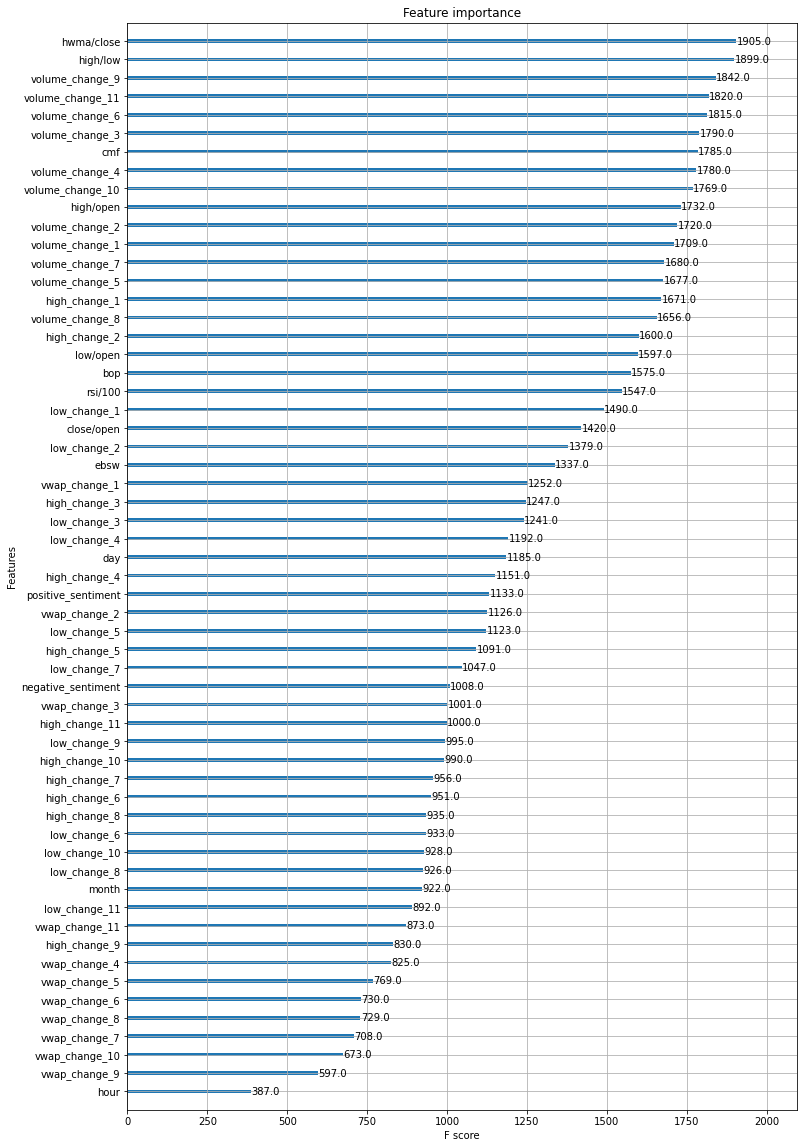

In [93]:
import xgboost
ax = xgboost.plot_importance(clf)
fig = ax.figure 
fig.set_size_inches(12, 20)


In [57]:
Y_pred = clf.predict(X_test) 
cnt = 0 
for i in range(len(Y_pred)):
    if Y_pred[i] == Y_test.values[i]:
        cnt += 1 
        
print("accuracy = {}%".format(cnt / len(Y_pred) * 100.))

accuracy = 46.06946983546618%


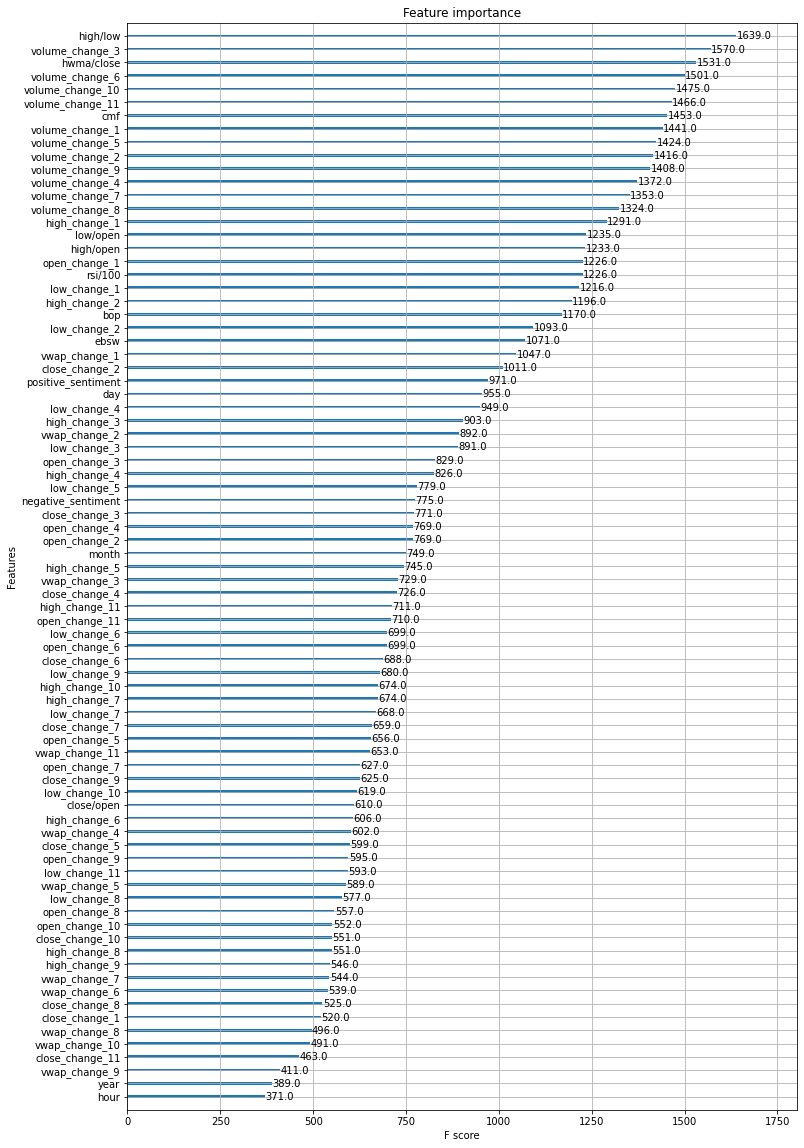

In [64]:
import xgboost
ax = xgboost.plot_importance(clf)
fig = ax.figure 
fig.set_size_inches(12, 20)


In [50]:
Y_pred = clf.predict(X_test) 
cnt = 0 
for i in range(len(Y_pred)):
    if Y_pred[i] == Y_test.values[i]:
        cnt += 1 
        
print("accuracy = {}%".format(cnt / len(Y_pred) * 100.))

accuracy = 43.51005484460695%


In [27]:
Y_pred = clf.predict(X_test) 
cnt = 0 
for i in range(len(Y_pred)):
    if Y_pred[i] == Y_test.values[i]:
        cnt += 1 
        
print("accuracy = {}%".format(cnt / len(Y_pred) * 100.))

accuracy = 43.144424131627055%
